# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey.rename(columns={'dbn': 'DBN'}, inplace=True)

In [3]:
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11"
]

In [4]:
survey = survey[survey_fields]

In [5]:
data["survey"] = survey

# Add DBN columns

In [6]:
data['hs_directory'].rename(columns={'dbn': 'DBN'}, inplace=True)
data['class_size']['padded_csd'] = data['class_size']['CSD'].astype(str).str.zfill(2)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

# Convert columns to numeric

In [7]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [8]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [9]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [10]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [11]:
combined['school_dist'] = combined['DBN'].str[:2]

# Find correlations

In [18]:
correlations = combined.corr()
correlations

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Grads - % of cohort,Total Regents - % of cohort,Total Regents - % of grads,...,expgrade_span_min,expgrade_span_max,number_programs,priority08,priority09,priority10,Community Board,Council District,lat,lon
SAT Critical Reading Avg. Score,1.000000,0.929221,0.982826,0.986820,0.379563,0.359807,0.359591,0.584661,0.659326,0.477195,...,NaN,NaN,0.111556,NaN,NaN,NaN,-0.059377,-0.071264,-0.119993,-0.126479
SAT Math Avg. Score,0.929221,1.000000,0.931385,0.972643,0.440178,0.414825,0.393285,0.541928,0.637366,0.493911,...,NaN,NaN,0.134403,NaN,NaN,NaN,-0.059206,-0.061451,-0.134572,-0.120055
SAT Writing Avg. Score,0.982826,0.931385,1.000000,0.987771,0.392009,0.367612,0.373210,0.598018,0.672042,0.485463,...,NaN,NaN,0.096834,NaN,NaN,NaN,-0.060942,-0.092805,-0.100551,-0.143850
sat_score,0.986820,0.972643,0.987771,1.000000,0.412667,0.388975,0.382931,0.584234,0.667603,0.494732,...,NaN,NaN,0.117012,NaN,NaN,NaN,-0.060919,-0.076151,-0.121029,-0.132222
AP Test Takers,0.379563,0.440178,0.392009,0.412667,1.000000,0.728800,0.841051,0.197545,0.260397,0.244341,...,NaN,NaN,0.385396,NaN,NaN,NaN,0.102292,0.127563,-0.166219,-0.017942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
priority10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Community Board,-0.059377,-0.059206,-0.060942,-0.060919,0.102292,0.053589,0.121138,0.003790,-0.017766,-0.029238,...,NaN,NaN,-0.027674,NaN,NaN,NaN,1.000000,0.235086,-0.157286,0.378804
Council District,-0.071264,-0.061451,-0.092805,-0.076151,0.127563,0.163508,0.125897,-0.083292,-0.091269,-0.088663,...,NaN,NaN,0.250976,NaN,NaN,NaN,0.235086,1.000000,-0.730447,-0.036960
lat,-0.119993,-0.134572,-0.100551,-0.121029,-0.166219,-0.209143,-0.138348,-0.045115,-0.069427,-0.065942,...,NaN,NaN,-0.229880,NaN,NaN,NaN,-0.157286,-0.730447,1.000000,0.280425


In [27]:
correlations = combined.corr()
correlations = correlations['sat_score']
for index, val in zip(combined.corr().index, correlations):
    print(index, '   -----   ', round(val, 2))

SAT Critical Reading Avg. Score    -----    0.99
SAT Math Avg. Score    -----    0.97
SAT Writing Avg. Score    -----    0.99
sat_score    -----    1.0
AP Test Takers     -----    0.41
Total Exams Taken    -----    0.39
Number of Exams with scores 3 4 or 5    -----    0.38
Total Grads - % of cohort    -----    0.58
Total Regents - % of cohort    -----    0.67
Total Regents - % of grads    -----    0.49
Advanced Regents - % of cohort    -----    0.77
Advanced Regents - % of grads    -----    0.74
Regents w/o Advanced - % of cohort    -----    -0.14
Regents w/o Advanced - % of grads    -----    -0.46
Local - % of cohort    -----    -0.47
Local - % of grads    -----    -0.49
Still Enrolled - % of cohort    -----    -0.49
Dropped Out - % of cohort    -----    -0.46
CSD    -----    0.04
NUMBER OF SECTIONS    -----    0.36
AVERAGE CLASS SIZE    -----    0.38
SIZE OF SMALLEST CLASS    -----    0.25
SIZE OF LARGEST CLASS    -----    0.31
SCHOOLWIDE PUPIL-TEACHER RATIO    -----    nan
schoolyea

# Plotting survey correlations

In [28]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove('DBN')

ValueError: list.remove(x): x not in list

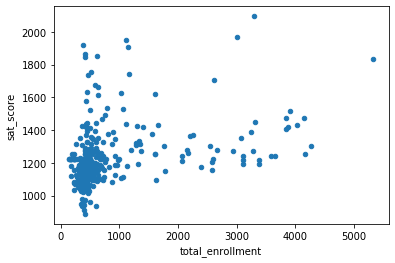

In [29]:
# Plot total enrollment and SAT scores
combined.plot(kind='scatter', x='total_enrollment', y='sat_score')

In [31]:
# List schools with low SAT scores and low enrollment
mask1 = combined['sat_score'] < 1000
mask2 = combined['total_enrollment'] < 1000
mask = mask1 & mask2
low_enrollment = combined[mask]
low_enrollment['School Name']

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

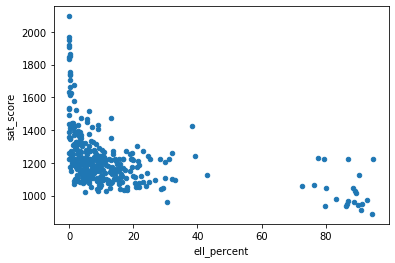

In [32]:
# Plot English language learners percent and SAT scores
combined.plot(kind='scatter', x='ell_percent', y='sat_score')

In [34]:
# Group data by school district
districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Grads - % of cohort,Total Regents - % of cohort,...,expgrade_span_min,expgrade_span_max,number_programs,priority08,priority09,priority10,Community Board,Council District,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,105.876423,140.212500,101.427007,71.333333,66.416667,...,0.0,12.0,1.333333,0.0,0.0,0.0,3.000000,1.500000,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,90.233943,116.819792,78.672141,75.453574,64.166074,...,0.0,12.0,1.416667,0.0,0.0,0.0,4.204005,2.963296,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,143.578049,114.200000,154.417883,74.029937,63.879937,...,0.0,12.0,2.000000,0.0,0.0,0.0,7.500000,6.500000,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,116.668293,146.385714,114.207508,76.257143,57.428571,...,0.0,12.0,1.142857,0.0,0.0,0.0,11.000000,8.000000,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,79.548432,96.978571,105.636079,75.200881,68.872309,...,0.0,12.0,1.142857,0.0,0.0,0.0,9.428571,8.142857,40.817077,-73.949251


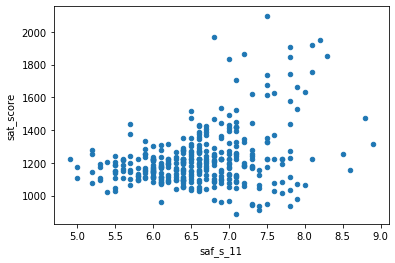

In [35]:
# Plot student school safety scores and SAT scores
combined.plot(kind='scatter', x='saf_s_11', y='sat_score')

It appears that in general, students tend to do better on SATs in schools they view as being safer. Interestingly, the 4 safest schools according to students all have combined SAT scores of less than 1,500.

In [47]:
#temp
for i in combined.columns:
    print(i)

DBN
SCHOOL NAME
Num of SAT Test Takers
SAT Critical Reading Avg. Score
SAT Math Avg. Score
SAT Writing Avg. Score
sat_score
SchoolName
AP Test Takers 
Total Exams Taken
Number of Exams with scores 3 4 or 5
Demographic
School Name
Cohort
Total Cohort
Total Grads - n
Total Grads - % of cohort
Total Regents - n
Total Regents - % of cohort
Total Regents - % of grads
Advanced Regents - n
Advanced Regents - % of cohort
Advanced Regents - % of grads
Regents w/o Advanced - n
Regents w/o Advanced - % of cohort
Regents w/o Advanced - % of grads
Local - n
Local - % of cohort
Local - % of grads
Still Enrolled - n
Still Enrolled - % of cohort
Dropped Out - n
Dropped Out - % of cohort
CSD
NUMBER OF SECTIONS
AVERAGE CLASS SIZE
SIZE OF SMALLEST CLASS
SIZE OF LARGEST CLASS
SCHOOLWIDE PUPIL-TEACHER RATIO
Name
schoolyear
fl_percent
frl_percent
total_enrollment
prek
k
grade1
grade2
grade3
grade4
grade5
grade6
grade7
grade8
grade9
grade10
grade11
grade12
ell_num
ell_percent
sped_num
sped_percent
ctt_num
se

In [48]:
# Analyze safety scores by borough
safety_scores_by_district = combined[['borough', 'saf_s_11', 'sat_score']]

In [49]:
safety_scores_by_district['sat_score'] = safety_scores_by_district['sat_score'].apply(lambda x: round(x, 0))
safety_scores_by_district['saf_s_11'] = safety_scores_by_district['saf_s_11'].apply(lambda x: round(x, 2))

C:\Users\isemenchuk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\isemenchuk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
safety_scores_by_district = safety_scores_by_district.pivot_table(index='borough', values='saf_s_11')
safety_scores_by_district.reset_index(inplace=True)
safety_scores_by_district

,borough,saf_s_11
0,Bronx,6.606559
1,Brooklyn,6.370755
2,Manhattan,6.831333
3,Queens,6.721875
4,Staten Island,6.530000


According to students' self scores of school safety, the safest schools are in Manhattan (6.83). The least safe schools are in Brooklyn (6.37).